# Hand labeling VAP data
The goal of this notebook is to fix the thermocldphase.c1 dataset when the thresholding algorithm fails.

Log:

LG: version 1 of this script written 06/03/2024

## 1. Import libraries

In [1]:
import os
import datetime
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cbook as cbook
import netCDF4
import xarray as xr
import pandas as pd
import glob
from typing import List
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.simplefilter('ignore')
from pathlib import Path
import seaborn as sns
from numpy.ma import log10
import itertools
from matplotlib.pyplot import subplots, colorbar, cm
import matplotlib.colors as mcolors
from numpy.ma import log10
from matplotlib.dates import date2num, DateFormatter, HourLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

## 2. Define Paths to Data on the computer

#### Using wild cards
Your computer has a limited amount of active memory. If you try to load in every data file stored on your hard drive, it'll crash the code. We will use wild cards in this script (*) to open just a select number of files at a time. Each file is uniquely named by the date at the time the data was collected. It also has its unique site identifier in the file name. For example:

For a file named sa120221126.nc, the parts of the file name are SSSYYYYMMDD.nc, where
- SSS is the site identifier sa1
- 2022 is the year YYYY
- 11 is the month MM
- 26 is the day DD
- .nc is the file name extension/ type, .nc means it is a netcdf file

Here's where the wild cards come in. We can predefine a month we want to examine in further detail, and use a wild card to grab every day. Loading in Sa1202211*.nc, will load in every file that matches Sa1202211 at the beginning and .nc at the end. If all our files are named the same, the wild card, *, will apply to all the days in that month, DD. Thus we will load in all the files for that month.

In [5]:
# This is the folder where the original data is stored
original_data_path = Path("C:\\Users\\harr732\\OneDrive - PNNL\\Documents\\Data") ##EDIT!

# This is the folder where you'll save the new data
hand_labeled_data_path = Path("C:\\Users\\harr732\\OneDrive - PNNL\\Documents\\Data\\data_2")##EDIT!

# This is the folder where you'll save the plots
# plots_path = Path("/home/goldberger/CLDPHS_VAP_Aircraft/Plots/")##EDIT!

In [6]:
year = '2018'##EDIT!
month = '01'##EDIT!

filelist = glob.glob(os.path.join(original_data_path, '*' + year + month + '*.nc'))
filelist.sort()
date_str_list = [filelist[mj][len(filelist[mj])-18:len(filelist[mj])-10] for mj in range(len(filelist))]
print(date_str_list)

['20180101', '20180102', '20180103', '20180104', '20180105', '20180106', '20180107', '20180108', '20180109', '20180110', '20180111', '20180112', '20180113', '20180114', '20180115', '20180116', '20180117', '20180118', '20180119', '20180120', '20180121', '20180122', '20180123', '20180124', '20180125', '20180126', '20180127', '20180128', '20180129', '20180130', '20180131']


#### 3. Define Functions

In plain language, functions in Jupyter notebooks (or in any programming context) are like recipes in a cookbook. They are sets of instructions that tell the computer how to perform a specific task.

When you make your own function, it follows a structure, define the name of your function, define the inputs, and define what the outputs of your function are eg.

lasagna = make_lasagna(noodles, sauce, cheese):
-    cook noodles
-   preheat oven
-   layer ingredients noodles, sauce, and cheese
-   bake
    
    return lasagna;

In [8]:
# This function loads in a single file

def getCLOUDVAP(date_input, date_str_list, filelist): # "YYYYMMDD"

    # Get Day
    try: 
        date_index = date_str_list.index(date_input)
    except ValueError:
        print('Check if date_input as a string in format YYYYMMDD.')
        print('Try a date between ' + date_str_list[0] + ' - ' + date_str_list[-1])

    # Get Data
    with xr.open_dataset(filelist[date_index]) as ds:
        ds
    time = ds['time'].data
    height = ds['height'].data
    cldphase_mplgr = ds['cloud_phase_mplgr'].data
    cldphase_layer_mplgr = ds['cloud_phase_layer_mplgr'].data
    mpl_dep = ds['mpl_linear_depol_ratio'].data
    mpl_backscat = ds['mpl_backscatter'].data * \
        (ds['height'].data**2)
    mpl_backscat[mpl_backscat <= 0] = 10**-9
    ds['mpl_backscatter'].data = mpl_backscat
    ds['mpl_backscatter'].attrs[
        'units'] = f"log10({ds['mpl_backscatter'].attrs['units']})"

    arscl_cloud_top = ds['cloud_layer_top_height'].data
    arscl_cloud_base = ds['cloud_layer_base_height'].data
    arscl_ze = ds['reflectivity_best_estimate'].data
    arscl_ze_snr = ds['radar_signal_to_noise_ratio'].data
    arscl_w = ds['spectral_width'].data
    arscl_mdv = ds['mean_doppler_velocity'].data
    combined_ze = arscl_ze.copy()
    combined_mdv = arscl_mdv.copy()
    combined_w = arscl_w.copy()
    mwr_lwp = ds['mwrret1liljclou_be_lwp'].data
    sonde_temp = ds['temp'].data

    mpl_backscat_ts = log10(mpl_backscat).transpose()

    cldphase_layer_pixel = np.zeros(mpl_backscat.shape, dtype=int)
    for j, k in itertools.product(range(0, len(time)), range(0, 10)):
        cloud_top_jk = arscl_cloud_top[j, k] * 0.001
        cloud_base_jk = arscl_cloud_base[j, k] * 0.001
        if(cloud_top_jk > 0) and (cloud_base_jk > 0):
            if(cldphase_layer_mplgr[j, k] == 1):
                cldphase_layer_pixel[j, np.where(
                    (height <= cloud_top_jk) & (height >= cloud_base_jk))] = 1
            if(cldphase_layer_mplgr[j, k] == 2):
                cldphase_layer_pixel[j, np.where(
                    (height <= cloud_top_jk) & (height >= cloud_base_jk))] = 2
            if(cldphase_layer_mplgr[j, k] == 3):
                cldphase_layer_pixel[j, np.where(
                    (height <= cloud_top_jk) & (height >= cloud_base_jk))] = 3

    return {"time": time, "height": height, "cldphase_mplgr": cldphase_mplgr,"cldphase_layer_mplgr": cldphase_layer_mplgr, "mpl_dep": mpl_dep, "mpl_backscat": mpl_backscat,"arscl_cloud_top": arscl_cloud_top, "arscl_cloud_base": arscl_cloud_base, "arscl_ze": arscl_ze, "arscl_ze_snr": arscl_ze_snr, "arscl_w": arscl_w, "arscl_mdv": arscl_mdv,"combined_ze": combined_ze, "combined_mdv": combined_mdv, "combined_w": combined_w,"mwr_lwp": mwr_lwp, "sonde_temp": sonde_temp, "mpl_backscat_ts": mpl_backscat_ts,"cldphase_layer_pixel": cldphase_layer_pixel}
# How to use:
# d = getCLOUDVAP('YYYYMMDD', date_str_list, filelist)
# time = d["time"]

In [9]:
# This function makes plots pretty :)

def set_axes(ax, font_size, font_weight, up_hgt, x_nvis,color_bar_label, padding):
    ax.set_xlabel(ax.get_xlabel(), fontsize=font_size, fontweight=font_weight)
    ax.set_ylabel(ax.get_ylabel(), fontsize=font_size, fontweight=font_weight)
    ax.set_title(ax.get_title(), fontsize=font_size, fontweight=font_weight)
    
    for tick in ax.get_xticklabels():
        tick.set_fontsize(font_size)
    
    for tick in ax.get_yticklabels():
        tick.set_fontsize(font_size)
        
    clrs = sns.color_palette("colorblind", 9)
    font = {'weight': font_weight, 'size': font_size}
    matplotlib.rc('font', **font)
    
    ax.set_ylim(0, up_hgt)
    plt.locator_params(axis='y', nbins=5)
    ax.set_ylabel('Height (km)')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", "3%", pad=padding)
    cb = colorbar(pplot, cax=cax)
    cb.ax.set_ylabel((color_bar_label))
    cb.ax.set_ylabel(cb.ax.get_ylabel(), fontsize=font_size, fontweight=font_weight)
    
    if x_nvis ==1:
        plt.setp(ax.get_xticklabels(), visible=False)
        
    return cb, ax
# # Example usage:
# fig, ax = plt.subplots()
# ax.plot([1, 2, 3, 4], [2, 4, 1, 3])

# # Call the function to set the font size for the axes
# set_axes(ax, 12, 'bold', 8, 1)

# plt.show()

### 4. Get Data

#### Using strings in filenames

Some intro to coding, a number is not just a number. There are different data types in python. 2, 2.0, and '2' each mean something slightly different. Read this link to learn more: https://cjtu.github.io/spirl/python_basic-types.html

For now we'll focus on strings. We use strings to call in the filename. We can combine strings to make a bigger string. We can use this to easily call different years and months of data without editing the exact code. This makes coding easier and faster after awhile. For example,

- year = '2023'
- month = '06'
- day = '25'

If I add these together, I combine these strings, I don't add them mathematically, eg

date = year + month + day

output: '20230625'



In [12]:
day = '10' ##EDIT!
date_input = year + month + day
print('This is the specific day: ' + date_input)

d = getCLOUDVAP(date_input, date_str_list, filelist)

This is the specific day: 20180110


### 5. Make plots

#### 4.1 Time Series Plot of Whole day

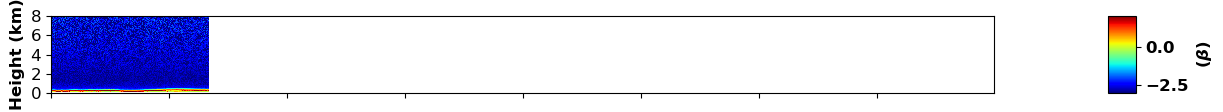

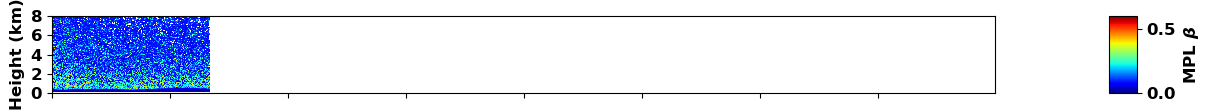

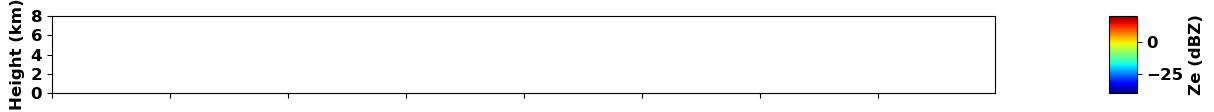

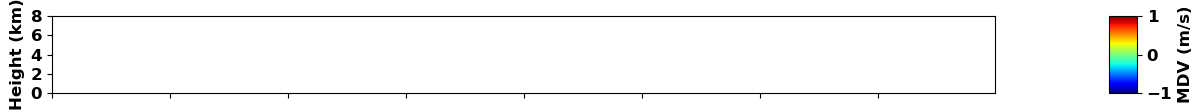

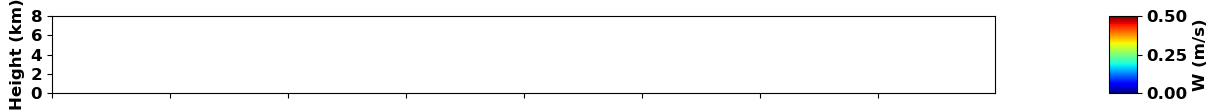

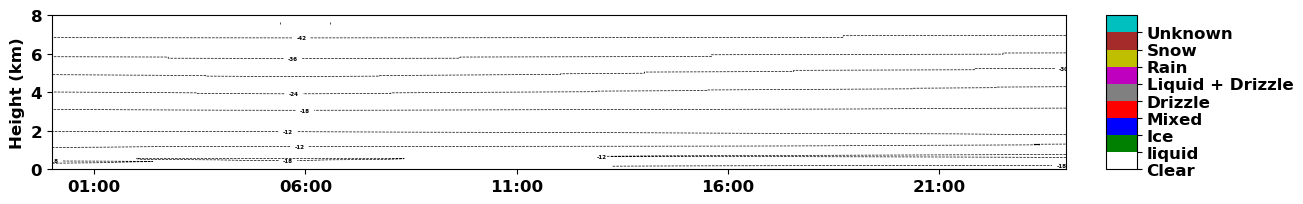

In [15]:
# Plot Radar and MPL Data
color_map = cm.get_cmap("jet")
# mpl backscatter
fig, (ax) = plt.subplots(1,1,figsize=(14,1), sharex=True, sharey=True)
pplot = ax.pcolormesh(d['time'], d['height'], d['mpl_backscat_ts'], vmin=-3, vmax=2, cmap=color_map, shading='auto')
set_axes(ax, 12, 'bold', 8, 1, r'($\beta$)',"12%")
# mpl_linear_depol_ratio
fig, (ax1) = plt.subplots(1,1,figsize=(14,1), sharex=True, sharey=True)
pplot = ax1.pcolormesh(d['time'], d['height'], d['mpl_dep'].transpose(),vmin=0, vmax=0.6, cmap=color_map, shading='auto')
set_axes(ax1, 12, 'bold', 8, 1,r'MPL $\beta$',"12%")
# radar Ze
fig, (ax2) = plt.subplots(1,1,figsize=(14,1), sharex=True, sharey=True)
pplot = ax2.pcolormesh(d['time'], d['height'], d['combined_ze'].transpose(),vmin=-40, vmax=20, cmap=color_map, shading='auto')
set_axes(ax2, 12, 'bold', 8, 1,'Ze (dBZ)',"12%")
# plot radar Doppler velocity
fig, (ax3) = plt.subplots(1,1,figsize=(14,1), sharex=True, sharey=True)
pplot = ax3.pcolormesh(d['time'], d['height'], d['combined_mdv'].transpose(),vmin=-1, vmax=1, cmap=color_map, shading='auto')
set_axes(ax3, 12, 'bold', 8, 1,'MDV (m/s)',"12%")
# plot radar Doppler spectra width
fig, (ax4) = plt.subplots(1,1,figsize=(14,1), sharex=True, sharey=True)
pplot = ax4.pcolormesh(d['time'], d['height'], d['combined_w'].transpose(),vmin=0, vmax=0.5, cmap=color_map, shading='auto')
set_axes(ax4, 12, 'bold', 8, 1,'W (m/s)',"12%")

################################

# Plot cloud phase datasets from ground

fig, (ax) = plt.subplots(1,1,figsize=(14,2), sharex=True, sharey=True)

# plot cldphase_pixel
cmap = ListedColormap(['w', 'g', 'b', 'r','gray','m','y','brown','c'])
pplot = ax.contour(d['time'], d['height'], d['sonde_temp'].transpose(),vmin=-40, vmax=40, levels = 9, colors = 'black', linestyles = '--',linewidths = 0.5)
ax.clabel(pplot,fontsize = 4,inline = True,fmt='%1.0f')
pplot = ax.pcolormesh(d['time'], d['height'], d['cldphase_mplgr'].transpose(),vmin=0, vmax=9, cmap=cmap, shading='auto')

cb, ax = set_axes(ax, 12, 'bold', 8, 0,'',"4%")

cb.ax.locator_params(nbins=8)
#cb.set_ticks([0.33, 1.33, 2.33, 3.33, 4.33, 5.33, 6.33, 7.33, 8.33])
cb.set_ticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
cb.set_ticklabels(['Clear', 'liquid', 'Ice', 'Mixed','Drizzle','Liquid + Drizzle','Rain','Snow','Unknown'])

date_fmt = DateFormatter('%H:00')
hour_loc = HourLocator(interval=5)
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_major_locator(hour_loc)


Notice in the cloud above the cyan lines. These are 'unknown', ie where the algorithm failed, we want to fix these values using context clues. 

Also note, sometimes the algorithm guesses real values, like mixed phase, among ice scattered as a pixel or two, like specks. These are also failures to correct.

In the case above I see two areas where the value is unknown. We will use the .sel feature to isolate these two cases, which stands for select.



In [17]:
# Open in xarray format for easier indexing

date_index = date_str_list.index(date_input)
with xr.open_dataset(filelist[date_index]) as ds:
        ds

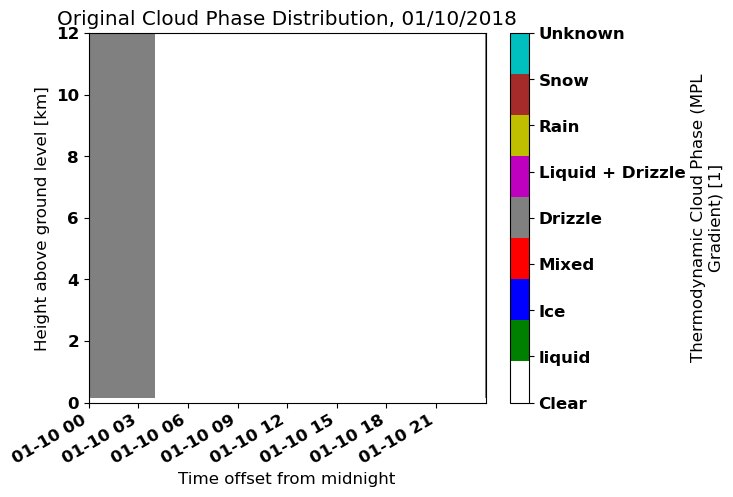

In [18]:
# Plot just the thermocld phase time series

plot = ds['cloud_phase_mplgr'].transpose().plot(cmap = cmap)
# Get the colorbar object from the plot
colorbar = plot.colorbar

# Add a title to the plot
plt.title('Original Cloud Phase Distribution, ' + month + '/' + day + '/' + year)

# Set y-axis limits
plt.ylim(0,12)

# Define new tick labels
new_tick_labels = ['Clear', 'liquid', 'Ice', 'Mixed','Drizzle','Liquid + Drizzle','Rain','Snow','Unknown']

# Set the new tick positions and labels
num_ticks = len(new_tick_labels)
tick_positions = np.linspace(colorbar.vmin, colorbar.vmax, num_ticks)
colorbar.set_ticks(tick_positions)
colorbar.set_ticklabels(new_tick_labels)

In [19]:
# Get selection we want to zoom in on
time_range = slice(pd.to_datetime(year + '-' + month + '-' + day +'T' + '00:00:00'), # manually input start time ##EDIT!
                   pd.to_datetime(year + '-' + month + '-' + day + 'T' + '10:00:00')) # manually input end time ##EDIT!

height_range = slice(7,11) ##EDIT!

ds_zoom = ds.sel(time = time_range, height = height_range)
ds_zoom

<xarray.Dataset>
Dimensions:                            (time: 1201, bound: 2, height: 134,
                                        layer: 10)
Coordinates:
  * time                               (time) datetime64[ns] 2018-01-10 ... 2...
  * height                             (height) float32 7.0 7.03 ... 10.96 10.99
  * layer                              (layer) int32 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: bound
Data variables: (12/47)
    base_time                          datetime64[ns] ...
    time_offset                        (time) datetime64[ns] ...
    time_bounds                        (time, bound) datetime64[ns] ...
    cloud_flag                         (time, height) float64 ...
    cloud_phase_hsrl                   (time, height) float64 ...
    qc_cloud_phase_hsrl                (time, height) int32 ...
    ...                                 ...
    mwrret1liljclou_be_pwv             (time) float32 ...
    mwrret1liljclou_tbsky23            (time) float32 ...
    mwrret1liljclou_tbsky31            (time) float32 ...
    lat                                float32 ...
    lon                                float32 ...
    alt                                float32 ...
Attributes: (12/57)
    command_line:                                      thermocldphase -s nsa ...
    Conventions:                                       ARM-1.3
    process_version:                                   vap-thermocldphase-0.3...
    dod_version:                                       thermocldphase-c1-1.3
    input_datastreams:                                 nsa30smplcmask1zwangC1...
    site_id:                                           nsa
    ...                                                ...
    hsrl_weak_backscatter_threshold_comment:           Backscatter threshold ...
    top_backscatter_grad_threshold:                    10.0
    top_backscatter_grad_threshold_comment:            Threshold of backscatt...
    base_backscatter_grad_threshold:                   1.0
    base_backscatter_grad_threshold_comment:           Threshold of backscatt...
    history:                                           created by user levin ...

- 0 = 'Clear', 
- 1 = 'liquid', 
- 2 = 'Ice', 
- 3 = 'Mixed',
- 4 = 'Drizzle',
- 5 = 'Liquid + Drizzle',
- 6 = 'Rain',
- 7 = 'Snow',
- 8 = 'Unknown'

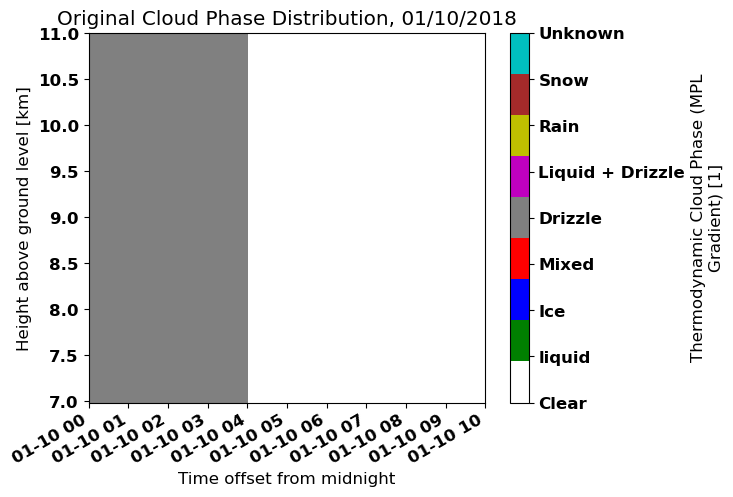

In [21]:
# Plot zoomed in section, here were going to make it a function for easier future plotting

def quicklook(dataset):
    plot = dataset['cloud_phase_mplgr'].transpose().plot(cmap = cmap)
    # Get the colorbar object from the plot
    colorbar = plot.colorbar

    # Add a title to the plot
    plt.title('Original Cloud Phase Distribution, ' + month + '/' + day + '/' + year)

    # Define new tick labels
    new_tick_labels = ['Clear', 'liquid', 'Ice', 'Mixed','Drizzle','Liquid + Drizzle','Rain','Snow','Unknown']

    # Set the new tick positions and labels
    num_ticks = len(new_tick_labels)
    tick_positions = np.linspace(colorbar.vmin, colorbar.vmax, num_ticks)
    colorbar.set_ticks(tick_positions)
    colorbar.set_ticklabels(new_tick_labels)
    return

# Try it out
quicklook(ds_zoom)

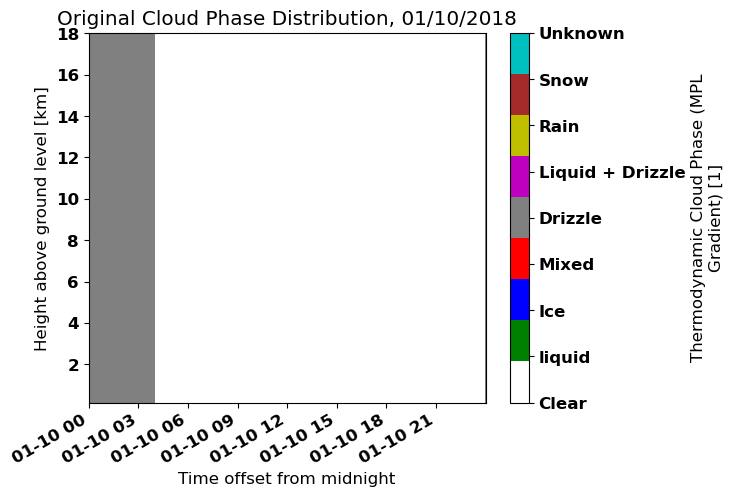

In [22]:
plot = ds['cloud_phase_mplgr'].transpose().plot(cmap = cmap)
# Get the colorbar object from the plot
colorbar = plot.colorbar

# Add a title to the plot
plt.title('Original Cloud Phase Distribution, ' + month + '/' + day + '/' + year)

# Define new tick labels
new_tick_labels = ['Clear', 'liquid', 'Ice', 'Mixed','Drizzle','Liquid + Drizzle','Rain','Snow','Unknown']

# Set the new tick positions and labels
num_ticks = len(new_tick_labels)
tick_positions = np.linspace(colorbar.vmin, colorbar.vmax, num_ticks)
colorbar.set_ticks(tick_positions)
colorbar.set_ticklabels(new_tick_labels)

In this case, all the unknown (cyan) we see is clearly supposed to be ice (blue).

Note we don't want to overwrite the original data, so were going to duplicate it, and in this section where we have unknown, were going to change it to ice.

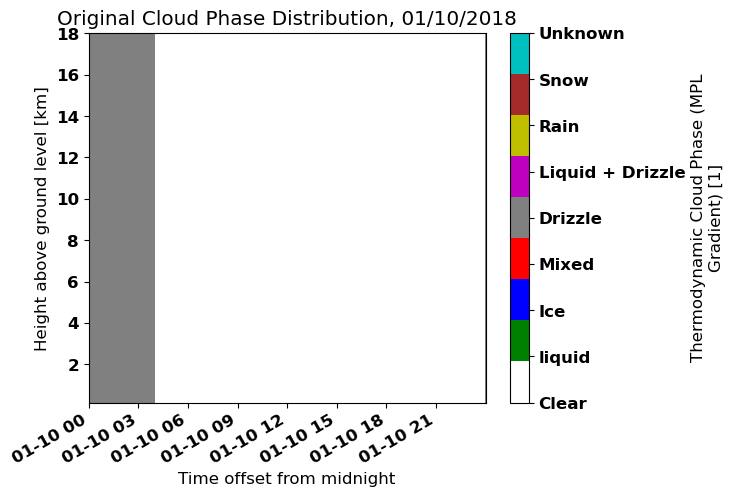

In [24]:
# Apply the `where` condition to the selected range
subset = ds['cloud_phase_mplgr'].sel(time=time_range, height=height_range)
modified_subset = subset.where(subset != 8, 4) ##EDIT! 8=unknown, 2=ice 


# # Update the original dataset
ds['cloud_phase_mplgr'].loc[{'time': time_range, 'height': height_range}] = modified_subset

modified_subset
# # Lets plot and check using the quick plot function we wrote
quicklook(ds)

Yay! All the stripe lines are gone

Now lets focus in on the unknown blob in the lowest part of the screen, I see three unknown blobs. Lets fix this in fewer lines of code

Notice below for the variables we're kind of using to temporaily look at the data, we'll over write, like ds_zoom below, we'll use the same variable names to zoom in on another portion of the dataset. Just so long as we don't overwrite the important variable names, reusing a name is a faster way to code where you can

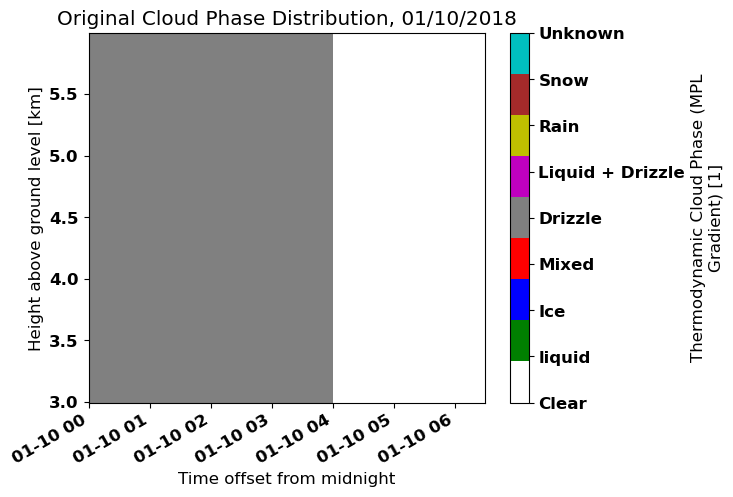

In [26]:
# Get selection we want to zoom in on
time_range = slice(pd.to_datetime(year + '-' + month + '-' + day +'T' + '00:00:00'), # manually input start time ##EDIT!
                   pd.to_datetime(year + '-' + month + '-' + day + 'T' + '6:30:00')) # manually input end time ##EDIT!

height_range = slice(3,6) ##EDIT!

ds_zoom = ds.sel(time = time_range, height = height_range)
quicklook(ds_zoom)



The cyan we see is surrounded by the brown color which represents snow, so we want to change these pixels to snow. We don't need to make another copy of the dataset. We want to modify ds_manual for a second time.

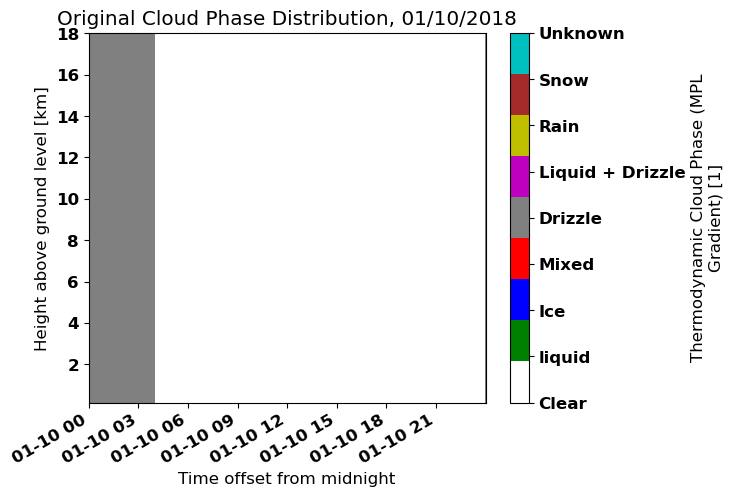

In [28]:
# Apply the `where` condition to the selected range
subset = ds['cloud_phase_mplgr'].sel(time=time_range, height=height_range)
modified_subset = subset.where(subset != 2, 2) ##EDIT! 7 = snow

# Update the original dataset
ds['cloud_phase_mplgr'].loc[{'time': time_range, 'height': height_range}] = modified_subset

# Lets plot and check using the quick plot function we wrote
quicklook(ds)

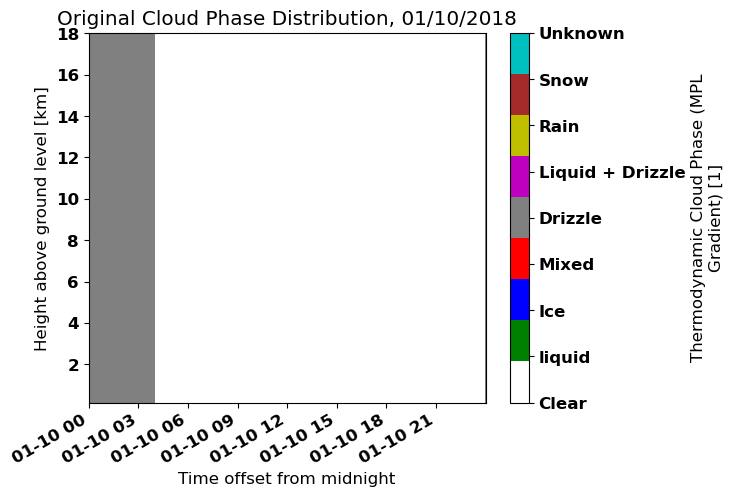

In [29]:
# Apply the `where` condition to the selected range
subset = ds['cloud_phase_mplgr'].sel(time=time_range, height=height_range)
modified_subset = subset.where(subset != 2, 2) ##EDIT! 7 = snow

# Update the original dataset
ds['cloud_phase_mplgr'].loc[{'time': time_range, 'height': height_range}] = modified_subset

# Lets plot and check using the quick plot function we wrote
quicklook(ds)

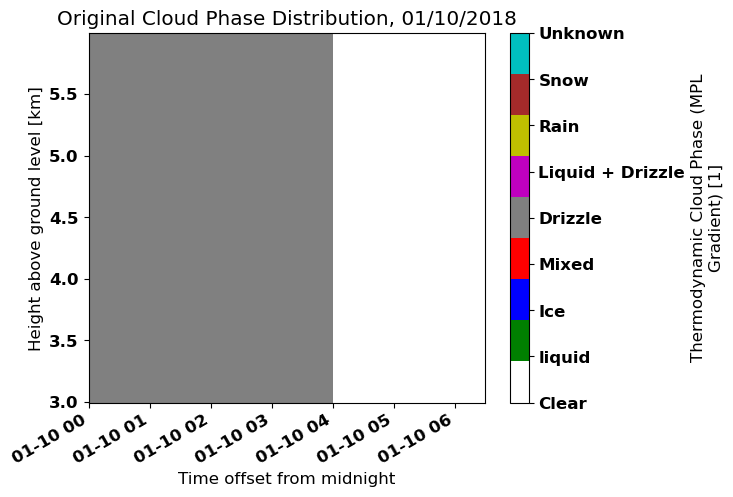

In [30]:
quicklook(ds.sel(time = time_range, height = height_range))

In [31]:
##### Get selection we want to zoom in on
time_range = slice(pd.to_datetime(year + '-' + month + '-' + day +'T' + '00:00:00'), # manually input start time ##EDIT!
                   pd.to_datetime(year + '-' + month + '-' + day + 'T' + '9:00:00')) # manually input end time ##EDIT!

height_range = slice(2,6) ##EDIT!

ds_zoom = ds_manual.sel(time = time_range, height = height_range)
quicklook(ds_zoom)



NameError: name 'ds_manual' is not defined

In [ ]:
# Apply the `where` condition to the selected range
subset = ds['cloud_phase_mplgr'].sel(time=time_range, height=height_range)
modified_subset = subset.where(subset != 8, ) ##EDIT! 7 = snow

# Update the original dataset
ds['cloud_phase_mplgr'].loc[{'time': time_range, 'height': height_range}] = modified_subset

# Lets plot and check using the quick plot function we wrote
quicklook(ds)

In [ ]:
quicklook(ds_manual)

In [ ]:
quicklook(ds)

Excellent! We've removed the unknown data, and properly labeled it as ice and snow where appropriate. We're ready to save our hand labeled dataset.

In other days you may need to itierate many times to remove and replace all the bad data

We'll save the file with the same name but in a different folder

In [ ]:
print('Original Filename: ' + filelist[date_index][-41:])

# Create new filename with path and name combined
new_file_name = os.path.join(hand_labeled_data_path, filelist[date_index][-41:])
print('new file: ' + str(new_file_name))

# Save file
ds_manual.to_netcdf(new_file_name)

print('Saved!')

In [ ]:
# Apply the `where` condition to the selected range
subset = ds['cloud_phase_mplgr'].sel(time=time_range, height=height_range)
modified_subset = subset.where(subset != 7, 2) ##EDIT! 7 = snow

# Update the original dataset
ds['cloud_phase_mplgr'].loc[{'time': time_range, 'height': height_range}] = modified_subset

# Lets plot and check using the quick plot function we wrote
quicklook(ds)

In [ ]:
##### Get selection we want to zoom in on
time_range = slice(pd.to_datetime(year + '-' + month + '-' + day +'T' + '00:00:00'), # manually input start time ##EDIT!
                   pd.to_datetime(year + '-' + month + '-' + day + 'T' + '9:00:00')) # manually input end time ##EDIT!

height_range = slice(2,6) ##EDIT!

ds_zoom = ds_manual.sel(time = time_range, height = height_range)
quicklook(ds)



In [ ]:
quicklook(ds.sel(time = time_range, height = height_range))

In [ ]:
print('Original Filename: ' + filelist[date_index][-41:])
 
# Create new filename with path and name combined
new_file_name = os.path.join(hand_labeled_data_path, filelist[date_index][-41:])
print('new file: ' + str(new_file_name))
 
# Save file
ds.to_netcdf(new_file_name)
 
print('Saved!')